## lstm

### 라이브러리

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style('whitegrid')
# plt.style.use("fivethirtyeight")
# %matplotlib inline

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import datetime

### 데이터 로드


*   pwd: 현재 경로 표시하기
*   cd drive/MyDrive/bigdata_project/data: 왼쪽 폴더 아이콘 누른 뒤 3번째 아이콘 눌러서 구글 드라이브를 마운트하고 다운 받은 엑셀파일이 저장된 경로를 찾아 들어가야함





In [53]:
/pwd

'/content/drive/MyDrive/bigdata_project/data'

In [54]:
cd drive/MyDrive/bigdata_project/data

[Errno 2] No such file or directory: 'drive/MyDrive/bigdata_project/data'
/content/drive/MyDrive/bigdata_project/data


In [55]:
ls

datareader_finbert_to_num_v2.xlsx
datareader_finbert_to_num.xlsx
datareader_finbert.xlsx
naver_finance_news.xlsx
naver_news.xlsx
preprocessed_dup_eliminated_dataset_finBERT.xlsx
report.xlsx
stock_dataset_finBERT_notnull.xlsx


In [58]:
# 로우 데이터로 엑셀파일 로드
# 실행 전에 미리 구글 드라이브 마운트를 해야하고 동일 경로에서 엑셀파일을 읽어들여야 함
raw_data = pd.read_excel('stock_dataset_finBERT_notnull.xlsx')
raw_data = raw_data.set_index("Date")
raw_data

,Open,High,Low,Close,Volume,Change,Rn,MRn,Volatility10,Volatility30,...,PSAR-up,RSI,ADX,OBV,OSCILLATOR,negative,neutral,positive,sentiment,Next_day
Date,,,,,,,,,,,,,,,,,,,,,
2017-06-01,44860,44900,44400,44680,195070,-0.000447,NaN,NaN,0.000000,0.000000,...,NaN,NaN,0.000000,195070,NaN,0.003329,0.071755,0.924916,1,45960
2017-06-02,45060,45960,45000,45960,249775,0.028648,1.028648,NaN,0.000000,0.000000,...,NaN,NaN,0.000000,444845,NaN,0.011197,0.002902,0.985901,1,45940
2017-06-05,46040,46360,45720,45940,151988,-0.000435,0.999565,NaN,0.000000,0.000000,...,NaN,NaN,0.000000,292857,NaN,0.005667,0.001626,0.992706,1,45300
2017-06-07,46500,46500,45240,45300,274588,-0.013931,0.986069,1.004761,0.000000,0.000000,...,45720.0,NaN,0.000000,18269,NaN,0.000138,0.000351,0.999511,1,45160
2017-06-08,45000,45580,45000,45160,279575,-0.003091,0.996909,0.994181,0.000000,0.000000,...,NaN,NaN,0.000000,-261306,NaN,0.000037,0.000082,0.999881,1,46100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-02,66600,67000,66400,66700,14959443,-0.010386,0.989614,1.001076,0.033406,0.070579,...,NaN,47.724304,10.877366,640155380,-22.352941,0.000585,0.499241,0.500174,1,66800
2022-06-03,67200,67300,66800,66800,8222883,0.001499,1.001499,0.995561,0.032744,0.070580,...,NaN,48.344501,10.158162,648378263,148.529412,0.001084,0.998356,0.000561,0,65500
2022-06-07,66200,66400,65400,65500,19355755,-0.019461,0.980539,0.990551,0.035700,0.072899,...,NaN,41.458445,10.635226,629022508,47.941176,0.000039,0.000086,0.999876,1,65300


In [62]:
raw_data.shape

(1234, 38)

### X, y 설정

             Open   High    Low  Close
Date                                  
2017-06-01  44860  44900  44400  44680
2017-06-02  45060  45960  45000  45960
2017-06-05  46040  46360  45720  45940
2017-06-07  46500  46500  45240  45300
2017-06-08  45000  45580  45000  45160
...           ...    ...    ...    ...
2022-06-02  66600  67000  66400  66700
2022-06-03  67200  67300  66800  66800
2022-06-07  66200  66400  65400  65500
2022-06-08  65400  65700  65300  65300
2022-06-09  65100  65200  64500  65200

[1234 rows x 4 columns]
            Next_day
Date                
2017-06-01     45960
2017-06-02     45940
2017-06-05     45300
2017-06-07     45160
2017-06-08     46100
...              ...
2022-06-02     66800
2022-06-03     65500
2022-06-07     65300
2022-06-08     65200
2022-06-09     63900

[1234 rows x 1 columns]


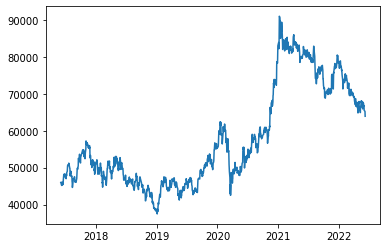

In [63]:
raw_X = raw_data.iloc[:, :4] # base 모델로 시, 고, 저, 종가만 추가했음
raw_y = raw_data.iloc[:, 37:38] # 다음날 종가 데이터가 들어있음
# 과거 데이터로 다음날 종가 데이터를 예측하는 lstm 모델을 만들 것임

print(raw_X)
print(raw_y)

plt.plot(raw_y, label = 'samsung')
plt.show()

### 전처리

In [64]:
# X, y 데이터를 0~1 사이 값으로 정규화 
# 학습이 잘되기 위해 하는 것이고, 이 값은 추후 inverse로 도로 되돌림
sc = MinMaxScaler()
sc_X = sc.fit_transform(raw_X)
sc_y = sc.fit_transform(raw_y)

train_size = int(len(sc_y) * 0.67)
test_size = len(sc_y) - train_size

# 텐서화? 하기
dataX = Variable(torch.Tensor(np.array(sc_X)))
dataY = Variable(torch.Tensor(np.array(sc_y)))

# train 데이터 2/3으로 자르기
trainX = Variable(torch.Tensor(np.array(sc_X[0:train_size])))
trainY = Variable(torch.Tensor(np.array(sc_y[0:train_size])))

# test 데이터 나머지 1/3으로 자르기
testX = Variable(torch.Tensor(np.array(sc_X[train_size:len(sc_X)])))
testY = Variable(torch.Tensor(np.array(sc_y[train_size:len(sc_y)])))

In [65]:
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

torch.Size([826, 4])
torch.Size([408, 4])
torch.Size([826, 1])
torch.Size([408, 1])


In [66]:
# lstm 모델에 적용할 때 shape을 변경해줘야 함 
# reshape(a, (b,1,c)) 형태로 모델에 돌리기 위해 2차원으로 바꿔주는 것임

trainX_fin = torch.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX_fin = torch.reshape(testX, (testX.shape[0], 1, testX.shape[1])) 

dataX_fin = torch.reshape(dataX, (dataX.shape[0], 1, dataX.shape[1]))
print("Training Shape", trainX_fin.shape, trainY.shape)
print("Testing Shape", testX_fin.shape, testY.shape) 
print(dataX_fin.shape, dataY.shape)

Training Shape torch.Size([826, 1, 4]) torch.Size([826, 1])
Testing Shape torch.Size([408, 1, 4]) torch.Size([408, 1])
torch.Size([1234, 1, 4]) torch.Size([1234, 1])


### 모델 정의

In [67]:
# 모델 정의하기

class LSTM(nn.Module):
    # Long Short Term Memory
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

# 레이어 추가 예시

# # 모델 만들기

# class LSTM(nn.Module):
#   def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
#     super(LSTM, self).__init__()
#     self.num_classes = num_classes #number of classes
#     self.num_layers = num_layers #number of layers
#     self.input_size = input_size #input size
#     self.hidden_size = hidden_size #hidden state
#     self.seq_length = seq_length #sequence length
 
#     self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
#                       num_layers=num_layers, batch_first=True) #lstm
#     self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
#     self.fc = nn.Linear(128, num_classes) #fully connected last layer

#     self.relu = nn.ReLU() 

#   def forward(self,x):
#     h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
#     c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state   
#     # Propagate input through LSTM

#     output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
   
#     hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
#     out = self.relu(hn)
#     out = self.fc_1(out) #first Dense
#     out = self.relu(out) #relu
#     out = self.fc(out) #Final Output
   
#     return out 


# print()

In [68]:
num_epochs = 2000
learning_rate = 0.01

input_size = 4 # 컬럼 개수
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, trainX_fin.shape[1])

loss_function = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm.forward(trainX_fin)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = loss_function(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.15522
Epoch: 100, loss: 0.00579
Epoch: 200, loss: 0.00294
Epoch: 300, loss: 0.00095
Epoch: 400, loss: 0.00054
Epoch: 500, loss: 0.00050
Epoch: 600, loss: 0.00046
Epoch: 700, loss: 0.00043
Epoch: 800, loss: 0.00040
Epoch: 900, loss: 0.00036
Epoch: 1000, loss: 0.00034
Epoch: 1100, loss: 0.00031
Epoch: 1200, loss: 0.00029
Epoch: 1300, loss: 0.00028
Epoch: 1400, loss: 0.00027
Epoch: 1500, loss: 0.00027
Epoch: 1600, loss: 0.00026
Epoch: 1700, loss: 0.00026
Epoch: 1800, loss: 0.00026
Epoch: 1900, loss: 0.00026


### 모델 평가

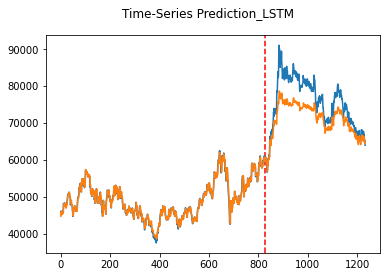

In [69]:
# 모델 평가하기
lstm.eval()

# 학습시킨 모델에 전체 데이터를 적용시켜 Y를 추출한 것
# 전체 데이터의 2/3인 train 데이터까지는 모델 학습에서 사용했던 데이터이고
# 1/3인 test 데이터는 모델이 예측한 값
train_predict = lstm(dataX_fin)

# 전체 데이터 예측 값(Y)을 numpy array로 변경
data_predict = train_predict.data.numpy()

# 실제 Y데이터 값을 numpy array로 변경
dataY_plot = dataY.data.numpy()

# 위에서 모델에 적용하려고 0~1 사이로 정규화했던 값을 다시 inverse
data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

# 학습에 사용됐던 데이터와 예측한 값의 경계를 선으로 표현
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction_LSTM')
plt.show()

### 평가지표 구하기

In [70]:
from sklearn.metrics import mean_squared_error

In [71]:
# 예측값: data_predict
# 실제값: dataY_plot

data_predict_fin = list(data_predict.flatten())
dataY_plot_fin = list(dataY_plot.flatten())

In [72]:
score_table = pd.DataFrame({'True': dataY_plot_fin,
                            'Pred': data_predict_fin})

In [73]:
score_table

,True,Pred
0,45960.000000,44664.539062
1,45940.000000,45882.253906
2,45300.000000,45867.558594
3,45160.000000,45411.335938
4,46100.000000,45064.289062
...,...,...
1229,66800.000000,65518.042969
1230,65500.003906,65610.875000
1231,65300.003906,64646.871094
1232,65200.003906,64375.285156


In [74]:
# validation score
MSE = mean_squared_error(score_table['True'], score_table['Pred'])
RMSE = np.sqrt(MSE)

score = 100*(1-(((score_table['Pred']-score_table['True'])**2).sum())/((score_table['True']**2).sum()))

In [75]:
print("MSE : {0}, RMSE : {1}, SCORE : {2}".format(MSE, RMSE, score))

MSE : 9234411.0, RMSE : 3038.8173828125, SCORE : 99.73809854127467


## 컬럼 추가 버전

In [90]:
raw_data = raw_data.fillna(0)
raw_data

,Open,High,Low,Close,Volume,Change,Rn,MRn,Volatility10,Volatility30,...,PSAR-up,RSI,ADX,OBV,OSCILLATOR,negative,neutral,positive,sentiment,Next_day
Date,,,,,,,,,,,,,,,,,,,,,
2017-06-01,44860,44900,44400,44680,195070,-0.000447,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,195070,0.000000,0.003329,0.071755,0.924916,1,45960
2017-06-02,45060,45960,45000,45960,249775,0.028648,1.028648,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,444845,0.000000,0.011197,0.002902,0.985901,1,45940
2017-06-05,46040,46360,45720,45940,151988,-0.000435,0.999565,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,292857,0.000000,0.005667,0.001626,0.992706,1,45300
2017-06-07,46500,46500,45240,45300,274588,-0.013931,0.986069,1.004761,0.000000,0.000000,...,45720.0,0.000000,0.000000,18269,0.000000,0.000138,0.000351,0.999511,1,45160
2017-06-08,45000,45580,45000,45160,279575,-0.003091,0.996909,0.994181,0.000000,0.000000,...,0.0,0.000000,0.000000,-261306,0.000000,0.000037,0.000082,0.999881,1,46100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-02,66600,67000,66400,66700,14959443,-0.010386,0.989614,1.001076,0.033406,0.070579,...,0.0,47.724304,10.877366,640155380,-22.352941,0.000585,0.499241,0.500174,1,66800
2022-06-03,67200,67300,66800,66800,8222883,0.001499,1.001499,0.995561,0.032744,0.070580,...,0.0,48.344501,10.158162,648378263,148.529412,0.001084,0.998356,0.000561,0,65500
2022-06-07,66200,66400,65400,65500,19355755,-0.019461,0.980539,0.990551,0.035700,0.072899,...,0.0,41.458445,10.635226,629022508,47.941176,0.000039,0.000086,0.999876,1,65300


### X, y 설정

             Open   High    Low  Close  sentiment
Date                                             
2017-06-01  44860  44900  44400  44680          1
2017-06-02  45060  45960  45000  45960          1
2017-06-05  46040  46360  45720  45940          1
2017-06-07  46500  46500  45240  45300          1
2017-06-08  45000  45580  45000  45160          1
...           ...    ...    ...    ...        ...
2022-06-02  66600  67000  66400  66700          1
2022-06-03  67200  67300  66800  66800          0
2022-06-07  66200  66400  65400  65500          1
2022-06-08  65400  65700  65300  65300          1
2022-06-09  65100  65200  64500  65200          1

[1234 rows x 5 columns]
            Next_day
Date                
2017-06-01     45960
2017-06-02     45940
2017-06-05     45300
2017-06-07     45160
2017-06-08     46100
...              ...
2022-06-02     66800
2022-06-03     65500
2022-06-07     65300
2022-06-08     65200
2022-06-09     63900

[1234 rows x 1 columns]


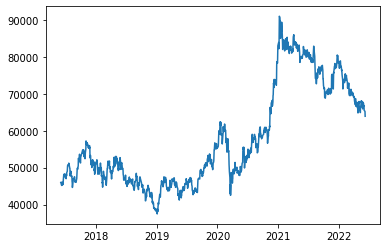

In [111]:
raw_X_b = raw_data.iloc[:,[0, 1, 2, 3, 36]] # 컬럼 추가 버전 (finbert 결과만 넣은 것임)
raw_y_b = raw_data.iloc[:, 37:38] # 다음날 종가 데이터가 들어있음
# 과거 데이터로 다음날 종가 데이터를 예측하는 lstm 모델을 만들 것임

print(raw_X_b)
print(raw_y_b)

plt.plot(raw_y_b, label = 'samsung')
plt.show()

### 전처리

In [112]:
# X, y 데이터를 0~1 사이 값으로 정규화 
# 학습이 잘되기 위해 하는 것이고, 이 값은 추후 inverse로 도로 되돌림
sc = MinMaxScaler()
sc_X_b = sc.fit_transform(raw_X_b)
sc_y_b = sc.fit_transform(raw_y_b)

train_size_b = int(len(sc_y_b) * 0.67)
test_size_b = len(sc_y_b) - train_size_b

# 텐서화? 하기
dataX_b = Variable(torch.Tensor(np.array(sc_X_b)))
dataY_b = Variable(torch.Tensor(np.array(sc_y_b)))

# train 데이터 2/3으로 자르기
trainX_b = Variable(torch.Tensor(np.array(sc_X_b[0:train_size_b])))
trainY_b = Variable(torch.Tensor(np.array(sc_y_b[0:train_size_b])))

# test 데이터 나머지 1/3으로 자르기
testX_b = Variable(torch.Tensor(np.array(sc_X_b[train_size:len(sc_X_b)])))
testY_b = Variable(torch.Tensor(np.array(sc_y_b[train_size:len(sc_y_b)])))

In [113]:
print(trainX_b.shape)
print(testX_b.shape)
print(trainY_b.shape)
print(testY_b.shape)

torch.Size([826, 5])
torch.Size([408, 5])
torch.Size([826, 1])
torch.Size([408, 1])


In [114]:
# lstm 모델에 적용할 때 shape을 변경해줘야 함 
# reshape(a, (b,1,c)) 형태로 모델에 돌리기 위해 2차원으로 바꿔주는 것임

trainX_b_fin = torch.reshape(trainX_b, (trainX_b.shape[0], 1, trainX_b.shape[1]))
testX_b_fin = torch.reshape(testX_b, (testX_b.shape[0], 1, testX_b.shape[1])) 

dataX_b_fin = torch.reshape(dataX_b, (dataX_b.shape[0], 1, dataX_b.shape[1]))
print("Training Shape", trainX_b_fin.shape, trainY_b.shape)
print("Testing Shape", testX_b_fin.shape, testY_b.shape) 
print(dataX_b_fin.shape, dataY_b.shape)

Training Shape torch.Size([826, 1, 5]) torch.Size([826, 1])
Testing Shape torch.Size([408, 1, 5]) torch.Size([408, 1])
torch.Size([1234, 1, 5]) torch.Size([1234, 1])


### 모델 정의

In [115]:
# 모델 정의하기

class LSTM(nn.Module):
    # Long Short Term Memory
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

# 레이어 추가 예시

# # 모델 만들기

# class LSTM(nn.Module):
#   def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
#     super(LSTM, self).__init__()
#     self.num_classes = num_classes #number of classes
#     self.num_layers = num_layers #number of layers
#     self.input_size = input_size #input size
#     self.hidden_size = hidden_size #hidden state
#     self.seq_length = seq_length #sequence length
 
#     self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
#                       num_layers=num_layers, batch_first=True) #lstm
#     self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
#     self.fc = nn.Linear(128, num_classes) #fully connected last layer

#     self.relu = nn.ReLU() 

#   def forward(self,x):
#     h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
#     c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state   
#     # Propagate input through LSTM

#     output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
   
#     hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
#     out = self.relu(hn)
#     out = self.fc_1(out) #first Dense
#     out = self.relu(out) #relu
#     out = self.fc(out) #Final Output
   
#     return out 


# print()

In [116]:
num_epochs = 2000
learning_rate = 0.01

input_size = 5 # 컬럼 개수
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, trainX_b_fin.shape[1])

loss_function = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm.forward(trainX_b_fin)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = loss_function(outputs, trainY_b)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.65319
Epoch: 100, loss: 0.00578
Epoch: 200, loss: 0.00479
Epoch: 300, loss: 0.00371
Epoch: 400, loss: 0.00262
Epoch: 500, loss: 0.00163
Epoch: 600, loss: 0.00092
Epoch: 700, loss: 0.00054
Epoch: 800, loss: 0.00043
Epoch: 900, loss: 0.00038
Epoch: 1000, loss: 0.00035
Epoch: 1100, loss: 0.00032
Epoch: 1200, loss: 0.00030
Epoch: 1300, loss: 0.00028
Epoch: 1400, loss: 0.00027
Epoch: 1500, loss: 0.00027
Epoch: 1600, loss: 0.00026
Epoch: 1700, loss: 0.00026
Epoch: 1800, loss: 0.00026
Epoch: 1900, loss: 0.00026


### 모델 평가

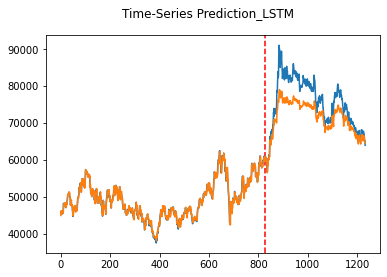

In [117]:
# 모델 평가하기
lstm.eval()

# 학습시킨 모델에 전체 데이터를 적용시켜 Y를 추출한 것
# 전체 데이터의 2/3인 train 데이터까지는 모델 학습에서 사용했던 데이터이고
# 1/3인 test 데이터는 모델이 예측한 값
train_predict_b = lstm(dataX_b_fin)

# 전체 데이터 예측 값(Y)을 numpy array로 변경
data_predict_b = train_predict_b.data.numpy()

# 실제 Y데이터 값을 numpy array로 변경
dataY_plot_b = dataY_b.data.numpy()

# 위에서 모델에 적용하려고 0~1 사이로 정규화했던 값을 다시 inverse
data_predict_b = sc.inverse_transform(data_predict_b)
dataY_plot_b = sc.inverse_transform(dataY_plot_b)

# 학습에 사용됐던 데이터와 예측한 값의 경계를 선으로 표현
plt.axvline(x=train_size_b, c='r', linestyle='--')

plt.plot(dataY_plot_b)
plt.plot(data_predict_b)
plt.suptitle('Time-Series Prediction_LSTM')
plt.show()

### 평가지표 구하기

In [118]:
from sklearn.metrics import mean_squared_error

In [119]:
# 예측값: data_predict
# 실제값: dataY_plot

data_predict_fin_b = list(data_predict_b.flatten())
dataY_plot_fin_b = list(dataY_plot_b.flatten())

In [120]:
score_table = pd.DataFrame({'True': dataY_plot_fin_b,
                            'Pred': data_predict_fin_b})

In [121]:
score_table

,True,Pred
0,45960.000000,44878.179688
1,45940.000000,46083.957031
2,45300.000000,46036.917969
3,45160.000000,45339.726562
4,46100.000000,45287.898438
...,...,...
1229,66800.000000,65733.492188
1230,65500.003906,65915.601562
1231,65300.003906,64695.554688
1232,65200.003906,64582.230469


In [122]:
# validation score
MSE = mean_squared_error(score_table['True'], score_table['Pred'])
RMSE = np.sqrt(MSE)

score = 100*(1-(((score_table['Pred']-score_table['True'])**2).sum())/((score_table['True']**2).sum()))

In [123]:
print("MSE : {0}, RMSE : {1}, SCORE : {2}".format(MSE, RMSE, score))

MSE : 8077374.0, RMSE : 2842.072021484375, SCORE : 99.77091380860656


## 전체 비교

1. base 모델 - MSE :  9,234,411.0, RMSE : 3038.8173828125, SCORE : 99.73809854127467

2. 모든 컬럼 추가 - MSE : 18,969,566.0, RMSE : 4355.40673828125, SCORE : 99.4619952980429

3. finbert만 추가 - MSE : 8,077,374.0, RMSE : 2842.072021484375, SCORE : 99.77091380860656

